# Introduction
Armed with a growing set of data analysis tools, I thought I’d take a shot at creating a model to predict the winner of the NBA’s annual MVP award. With the stats repository Basketball-Reference.com as my playground and on the verge of jumping in, I heard a solemn voice call from the pages of one of the best statistical analysis texts that I’ve found, Getting Started with Data Science by Murtaza Haider. Exactly what he said, I’ll never reveal. But it did get me thinking about doing some literature review - that is, what other work might I find on this topic?

You can follow this link to find the point where my target pivoted a bit. Initially, I was inclined to use individual stats as predictors for MVP outcomes. An unoriginal approach, sure, but something that would get the ball rolling. Their analysis found that using a combination of traditional stats (‘points per game’ etc) and so-called advanced stats, one could predict with a high degree of accuracy the winner of the vote. They concluded that the shortcomings of their model could be explained by the narrative that accompanies every MVP race, variously hyping up and toppling contenders over the course of the season.

I thought this would be a more interesting angle to explore and so from here I changed direction to give more consideration to the narrative context of the race. My hypothesis: the narrative factor is largely a reflection of team success. Why is team success so important? The fans and media alike are attracted to winning teams, focusing a greater spotlight on the players of those teams. Secondly, and more importantly, the best players are able to drive their teams to success. What value can a player have if their production doesn’t translate into wins. The ‘V’ ought to stand for something.

My favorite part of this theory: it’s simple. And simple beats complicated ten out of sin(3/1-e2) times. As a regular season award, we can base our analysis on the Wins-Loss record of past MVP winners. And with that let’s dig into the numbers.

# Gathering Data
Basketball-Reference.com ('BBR') provides records of each annual MVP vote that include the following data of interest: player name and team, first-place votes, total points won, and share of total points. Total points are a weighted measure of votes cast per player, found by taking the sum of each vote received after it has been multiplied by a scaled number (first place votes are multiplied by twelve points while second-place and below by smaller factors). Share of total points is the proportion of total points earned to maximum achievable points during that year. Because first-place votes are the only one enumerated, share of total points is the only indicator that BBR provides for how voters cast their other votes.

In [372]:
#For clarity's sake, I'll import dependant libraries as needed
import numpy as np
import pandas as pd
import sqlite3

#connect to db and create container for voting data
db = sqlite3.connect('mvp_db')
df = pd.read_sql_query('SELECT * FROM mvp_voting',db)
df.head()

,id,year,vote_rank,player_name,player_age,player_team,first_place_votes,total_points,max_points,wins_curr_year,wins_one_prior,wins_two_prior,wins_three_prior,wins_four_prior,wins_five_prior
0,1,2000,1,Shaquille O'Neal,27,LAL,120,1207,1210,67,51.0,61.0,56.0,53.0,48.0
1,2,2000,2,Kevin Garnett,23,MIN,0,408,1210,50,41.0,45.0,40.0,26.0,21.0
2,3,2000,3,Alonzo Mourning,29,MIA,0,367,1210,52,54.0,55.0,61.0,42.0,32.0
3,4,2000,4,Karl Malone,36,UTA,0,312,1210,55,61.0,62.0,64.0,55.0,60.0
4,5,2000,5,Tim Duncan,23,SAS,0,248,1210,53,61.0,56.0,20.0,59.0,62.0


It's worth pausing to conisder at this early stage the possible impact that the incomplete vote counts will have on our analysis. Let's take a look at the relationship between First Place Votes and Vote Share. What we're looking for here is an indication that second- and third-place votes have enough of an impact on total points to change the final outcome. And we can do that by looking for any years where the MVP winner was not also the leader in First Place Votes

In [6]:
#Did any MVP winners not also lead in first place votes?
first_place_votes = df.groupby('year')['first_place_votes'].rank(ascending=False)
first_place_votes = first_place_votes.astype('int')
df1 = pd.concat([df['vote_rank'], first_place_votes], axis=1)
df1[(df1['vote_rank']==1) & (df1['vote_rank'] != df1['first_place_votes'])]

,vote_rank,first_place_votes


So for each year in our dataset, the MVP winner received the greatest share of first-place votes. We can't use this finding to conclude that we've found a rule and go on to use first-place votes as a proxy for total points. But it does raise some questions about the direction of our analysis and even our ultimate choice for machine learning alogrithm. If the MVP race is a winner-take-all race, maybe we should consider ways of classifying players by place in the final vote, as opposed to the linear regression strategy of predicting points distributions within each race (the approach taken by the analysis mentioned above). Going one step further, we might want to try a binary approach: 1 for First-Place getters and 0 for all others. This suggests logistic regression as an option.

# Distribution of Data

How valid are those options? It all depends on how points and votes are distrbuted. Let's draw up some histograms.

(array([240.,  11.,   1.,   3.,   5.,   1.,   4.,   2.,   3.,   5.]),
 array([  0. ,  13.1,  26.2,  39.3,  52.4,  65.5,  78.6,  91.7, 104.8,
        117.9, 131. ]),
 <a list of 10 Patch objects>)

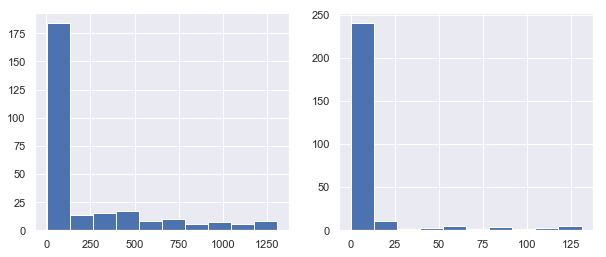

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(df['total_points'])
axes[1].hist(df['first_place_votes'])

Immediately we see that a majority or near-majority of contestants receive a minimal share of total points - a few third and fourth place votes scattered about. The chart on the right (distribution of first-place votes) is even more stark. First-place votes - the strongest predictor of success in this race - are even less uniformly distributed with most contestants earning no votes. How many came up empty in this category?

In [69]:
print(len(df[df['first_place_votes']==0]))

204


That's 204 out of 275 entries. I'm concerned that including them in our regression is going to be unproductive because of the lack of parametric linearity. Do we discard them altogether or choose another cutoff for shaping up our dataset? Lets' take another look at the data and see if we can learn anything from the averages of each rank.

In [70]:
df.groupby('vote_rank').mean().head(6)

,id,year,player_age,first_place_votes,total_points,max_points,wins_curr_year,wins_one_prior,wins_two_prior,wins_three_prior,wins_four_prior,wins_five_prior
vote_rank,,,,,,,,,,,,
1,138.105263,2009.0,26.736842,93.947368,1111.789474,1218.421053,61.157895,53.421053,48.789474,46.473684,45.947368,39.947368
2,139.105263,2009.0,26.105263,18.578947,777.947368,1218.421053,55.842105,48.736842,47.631579,41.894737,38.368421,41.263158
3,140.105263,2009.0,27.315789,5.000000,524.578947,1218.421053,54.789474,47.842105,45.105263,44.473684,43.736842,43.684211
4,141.105263,2009.0,27.421053,2.578947,370.578947,1218.421053,52.000000,51.421053,52.631579,49.421053,45.315789,41.315789
5,142.105263,2009.0,25.842105,1.473684,176.631579,1218.421053,51.894737,49.052632,45.526316,42.631579,46.842105,47.947368
6,143.105263,2009.0,27.157895,0.052632,87.105263,1218.421053,49.578947,48.000000,47.526316,44.000000,42.684211,41.947368


# Selecting Regressors

We observe that around rank 4/5, wins in the voting year level off near 50. We also see that the teams of top vote-getters on average exhibit significant improvement over each of the two prior seasons. I haven't yet mentioned why we included the prior year win totals and now is a good time to touch on that. Wins alone might explain media coverage (and the attention of voters) but people are also drawn to change. We see here that not only do high-finishers come from successful teams, but their teams (on average) show marked improvement over the previous two years. Perhaps that's explainable by the impact of the team's top player. It's an interesting idea and it appears to have some backing in the data.

We'll use these two points to establish our cutoff and concentrate our analysis: Wins in the current year, and wins of the two preceding years. Let's check out the univariate relationships those data have with our target.

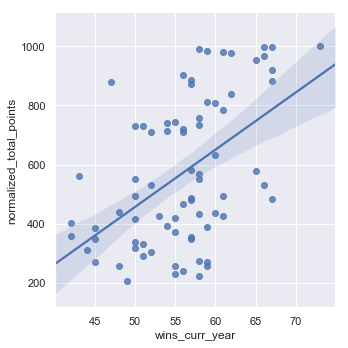

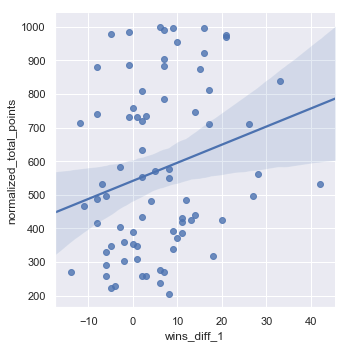

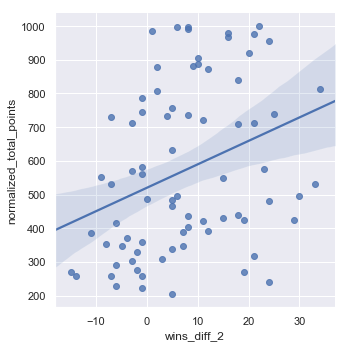

In [77]:
sns.lmplot('wins_curr_year', 'normalized_total_points', data=df)
sns.lmplot('wins_diff_1', 'normalized_total_points', data=df)
sns.lmplot('wins_diff_2', 'normalized_total_points', data=df)

We see a pretty recognizable positive trend (though not terribly strong) when MVP points are plotted against wins from the current season. That's exactly what we expected. The better your team is performing in the current year, the more seriously voters are likely to take it's players as valuable, and it's best player into MVP conisderation. The relationships involving improvement are much more dubious, but do show a positive relationship which again we were expecting.

Now that we have our predictors, we can do our final trims of the dataset and get into fitting an ordinary least squares model.

In [269]:
df = df[pd.to_numeric(df['vote_rank'], errors='coerce').notnull()]
df =df[df['vote_rank'].astype('int32') <5]

To more easily interpret the data we'll create columns to express the net change in wins over the two preceding years. We'll also create a new column to show final vote counts, standardized across all years of the dataset.

In [209]:
df['wins_diff_1'] = df['wins_curr_year'] - df['wins_one_prior']
df['wins_diff_2'] = df['wins_curr_year'] - df['wins_two_prior']
df['normalized_total_points'] = df['total_points']/df['max_points']*1000

#dropping extraneous columns
df.drop(['id', 'total_points', 'player_team', 'player_age', 'max_points', 'wins_one_prior', 'wins_two_prior', 'wins_three_prior'
,'wins_four_prior', 'wins_five_prior'], axis=1, inplace=True)
df.head()

,year,vote_rank,player_name,first_place_votes,wins_curr_year,wins_diff_1,wins_diff_2,normalized_total_points
0,2000,1,Shaquille O'Neal,120,67,16.0,6.0,997.520661
1,2000,2,Kevin Garnett,0,50,9.0,5.0,337.190083
2,2000,3,Alonzo Mourning,0,52,-2.0,-3.0,303.305785
3,2000,4,Karl Malone,0,55,-6.0,-7.0,257.851240
16,2001,1,Allen Iverson,93,56,7.0,10.0,904.032258


Just before fitting to our regression model, I'll make a note that our data going into the model is solidly non-normal. But what linear regression requires is normality of our *residuals*, not of our predictors. We'll take a look at that shortly.

# Fitting the Model

In [210]:
#import, fit, and score the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df[['wins_curr_year', 'wins_diff_1', 'wins_diff_2']]
y= df[['normalized_total_points']]

model = LinearRegression()
model.fit(X,y)
predictions = model.predict(X)
r2_score(y, predictions)

0.28128957925454035

For now, I'm primarily interested in fit, not prediction value, so I haven't used holdout sets or calculated mean squared errors. And besides, we'll be looking at residuals to inform us on prediction error and in a simple model like this, that might be as useful as testing against independent (holdout) cases. So what does the model say? 

It looks like our model isn't terribly predictive. Recent team performance only explains 28% of variation on total MVP points. But then, again, that's pretty significant! Team performance is a non-trivial factor in determining the MVP, and that's what we'd expect: better teams yield more MVPs.

Now, how about those residuals?

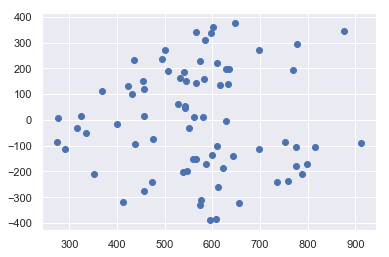

In [150]:
residuals = predictions - y
plt.scatter(predictions, residuals) 

I'm not picking up any obvious patterns here, which is what we want. Let's look at their distribution:

(array([ 5.,  6.,  8., 13.,  5.,  9.,  7., 10.,  6.,  6.]),
 array([-390.19283422, -313.45033855, -236.70784289, -159.96534722,
         -83.22285155,   -6.48035588,   70.26213978,  147.00463545,
         223.74713112,  300.48962679,  377.23212245]),
 <a list of 10 Patch objects>)

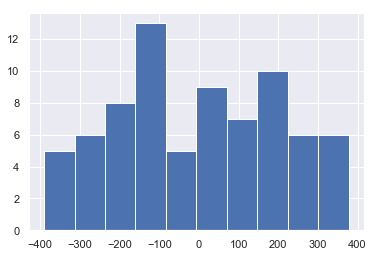

In [153]:
plt.hist(residuals['normalized_total_points'])

# Outliers, High-Leverage Points, and Normality
Well that's not looking terribly normal, which is concerning. Do we have to tear up our model? Maybe not - we haven't yet talked about outliers or other points that might negatively impact our model. If we're able to identify any, remvoing them from our dataset might improve performance.

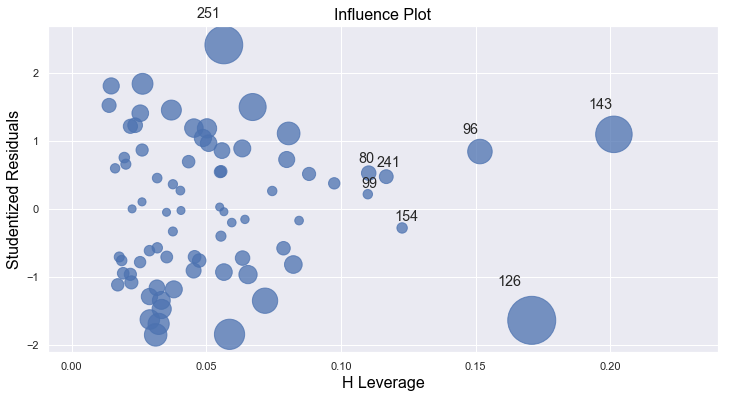

In [120]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sm_model = smf.ols('normalized_total_points ~ wins_curr_year + wins_diff_1 + wins_diff_2', data = df).fit()
fig, ax = plt.subplots(figsize=(12,6))
sm.graphics.influence_plot(sm_model, ax=ax);
#print(sm_model.summary)

We have a few points of concerns. Let's see what's going on with 251, 126, and 143.

In [140]:
df.loc[[251, 126, 143]]

,year,vote_rank,player_name,first_place_votes,wins_curr_year,wins_diff_1,wins_diff_2,normalized_total_points
251,2017,1,Russell Westbrook,69,47,-8.0,2.0,879.207921
126,2008,3,Kevin Garnett,15,66,42.0,33.0,531.746032
143,2009,3,Dwyane Wade,7,43,28.0,-1.0,561.983471


The two that jump out the most to me are Westbrook and Garnett. Wade's residual is large, but not alarming. We can understand the high leverage of his data as coming from both a subpar record during the voting year (43 is just below league average - not MVP territory) and a huge win difference over the previous year. What we need to ask is if this point breaks the assumptions of this model, and if it does, excise it from the dataset. While Wade and Garnett's rankings might not be justified by our model, they don't necessarily corrupt it.

Westbrook's year I'll treat differently in light of my domain knowledge here. Westbrook's MVP season was treated by the media very differently than all others and I would argue that it breaks the standard assumptions that go both into MVP voting and our regresion model. It comes out. Let handle that and then re-run our models.

0.3219147395585662


(array([ 5.,  6.,  8., 13.,  5.,  9.,  7., 10.,  6.,  6.]),
 array([-390.19283422, -313.45033855, -236.70784289, -159.96534722,
         -83.22285155,   -6.48035588,   70.26213978,  147.00463545,
         223.74713112,  300.48962679,  377.23212245]),
 <a list of 10 Patch objects>)

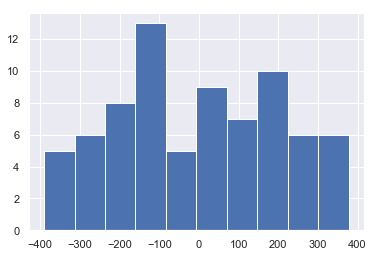

In [211]:
df = df.drop(251, axis=0)
X = df[['wins_curr_year', 'wins_diff_1', 'wins_diff_2']]
y= df[['normalized_total_points']]

model = LinearRegression()
model.fit(X,y)
predictions = model.predict(X)
print(r2_score(y, predictions))
plt.hist(residuals['normalized_total_points'])

Mixed results! After removing one outlier, our r-squared shot up to .32, which is unsurprising and good to see. On the other hand, we didn't get much of a change in the shape of our residuals histogram. That too is not so surprising given that we didn't touch the other values. I'm not ready to throw away our model just yet, so let's apply some tools to investigate normality by plotting a KDE chart, running a QQ plot, and then doing some numerical tests for normality. 

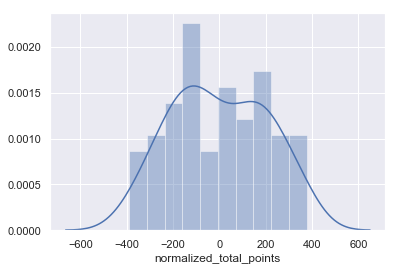

In [158]:
sns.distplot(residuals['normalized_total_points'], bins=10, kde=True)

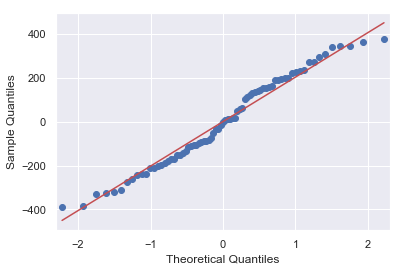

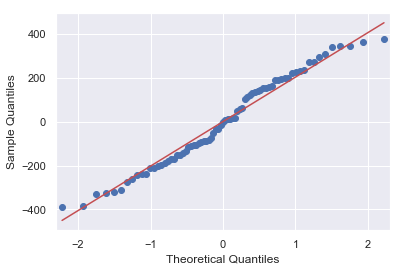

In [161]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals['normalized_total_points'], line='s')

In [169]:
from scipy.stats import normaltest
normaltest(residuals['normalized_total_points'])

NormaltestResult(statistic=10.269507950928896, pvalue=0.0058885000425045065)

Good thing we have those tests, all three measures indicate that the residuals distribution is sufficiently normal to stick with our linear regression model. That's great!

# Almost there...

What now? Well, we started this whole exercise to determine the predictive power of this simple model that focuses on team performance. Let's see how it does.

In [213]:
#df['predictions'] = predictions
#re-rank players based on their predicted vote totals
df['predicted_rank'] = df.groupby('year')['predictions'].rank(ascending=False)
compare = df[['year', 'vote_rank', 'predicted_rank']]
compare[(compare['vote_rank'] != compare['predicted_rank']) & (compare['vote_rank']==1)]

,year,vote_rank,predicted_rank
16,2001,1,2.0
64,2004,1,2.0
96,2006,1,2.0
124,2008,1,2.0
181,2012,1,2.0


**Holy cow. So our .32 r-squared model that only looks at team wins over the last three seasons correctly ranked the MVP winner in fourteen of the nineteen years in our dataset. Cool!**

Let's look at a fuller report on our model.

In [228]:
sm_model = smf.ols('normalized_total_points ~ wins_curr_year + wins_diff_2', data = df).fit()
print(sm_model.summary())

                               OLS Regression Results                              
Dep. Variable:     normalized_total_points   R-squared:                       0.317
Model:                                 OLS   Adj. R-squared:                  0.298
Method:                      Least Squares   F-statistic:                     16.73
Date:                     Thu, 29 Nov 2018   Prob (F-statistic):           1.08e-06
Time:                             17:41:22   Log-Likelihood:                -505.00
No. Observations:                       75   AIC:                             1016.
Df Residuals:                           72   BIC:                             1023.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Those are some extremely concerning p-values. We really can't have confidence in the impact that prior seasons' win totals have in our model. Wins from the current year is standing strong but that's it.

So we'll want to keep wins from the current year in our model - but do the other two have to go? Re-running the regression with the current year and then *either* of the two other factors gave us a better p-values with little impact on r-squared. Winn_Diff_2 showed a o-value of .165. Not a greet value - far above our threshold for significance (.05). Do we have to get rid of it?

Not necessarily. There is an issue of multicollinearity in that strong year-over-year improvements will necessarily yield high win totals. And it's clear that win totals are the dominant force among our conisdered variables. The high p-value suggests that the model can effectively rule out the null hypothesis that the wins differential is not a signifcant contributor. Yet it'd inclusion does improve the model and I'm inclined to leave it in or model.

# Wrapping-Up
That was a fun exercise! We found pretty interesting predicitve power in simple win-loss counts on MVP votes. Our model correctly predicted the winner 14/19 times based solely on wins/loss records. This isn't an earth-shattering finding, but it is a cool way to add some color to the 'narrative' aspect of the MVP race. Is narrative based solely on team success? No, but it certainly plays a part, as shown by the ability of our two-variable rgression model to select the winner based off of wins in the current season and from two years prior.

While this was interesting, it leaves a lot of stones unturned. What other algorithms might we use that have greater predictive power? What about building my own full-blown regression model for MVP, this time incorporating both individual stats and narrative factors like team stats. That's an exercise where I can apply some more advanced data/machine learning skills like tuning of model parameters, stepwise regression, cross-validation, and more!